In [ ]:
#U-Net training without any training metric for multiclass segmentation without dense layer (960x960 and dropout)

In [1]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from dataset import LoadData, PreprocessData
from model import EncoderMiniBlock, DecoderMiniBlock, UNetCompiled
# from unet_pretrained import unet_model
import math
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import backend as K
from IPython.display import clear_output

%load_ext tensorboard
# Clear any logs from previous runs
# rm -rf ./logs/

2023-05-25 13:27:48.684546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:27:48.833221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 13:27:49.688227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/skylake_avx512/software/cuDNN/8.4.1.50-CUDA-11.6.0/lib:/cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/skylake_avx512/software/CUDA/11.6.0/nvvm/lib64:

In [ ]:
def VisualizeResults(start, index):
    
    fig, arr = plt.subplots(index - start, 3, figsize=(50, 50))
    for disp in range(start, index):        
        img = X_valid[disp]
        img = img[np.newaxis, ...]
        pred_y = unet.predict(img)
        print(pred_y.min(), pred_y.max())
        threshold = 0.0
        pred_y[pred_y > threshold] = 1.0
        pred_y[pred_y < threshold] = 0.0
        pred_y = pred_y.squeeze()
        print(pred_y.min(), pred_y.max())
        #simple numpy addition
        # result_true = X_valid[index].copy()
        # result_true[y_valid[index,:,:,0]!=0] += (0.6,0.6,0)
        
        #simple numpy addition
        # result_pred = X_valid[index].copy()
        # result_pred[pred_y!=0] += (0.6,0.6,0)
        if index-start > 1:
            arr[disp-start][0].imshow(X_valid[disp],cmap="gray")
            arr[disp-start][0].set_title('Image')
            arr[disp-start][1].imshow(y_valid[disp])
            arr[disp-start][1].set_title('Actual Mask')
            arr[disp-start][2].imshow(pred_y)
            arr[disp-start][2].set_title('Predicted Mask ')
        else:
            arr[0].imshow(X_valid[disp])
            arr[0].set_title('BLAH')
            arr[1].imshow(y_valid[disp]*255)
            arr[1].set_title('Actual Mask')
            arr[2].imshow(pred_y*255)
            arr[2].set_title('Predicted Mask ')
            
    plt.show()
    # plt.plot(arr[0], arr[1])

In [2]:
path1 = '/work/ma015125/annotations/'
path2 = '/work/ma015125/annotations/'

model_path = '/work/au321555/hiwi/model/multiclass_model_25-05_480x480x1/'

checkpoint_filepath = model_path + 'checkpoints/'
#log_dir = model_path + 'log/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = '/work/au321555/hiwi/logs/multiclass_model_25-05_480x480x1'

img, mask = LoadData (path1, path2)

target_shape_img = [480, 480, 1]
target_shape_mask = [480, 480, 1]

#target_shape_img = [960,960, 1]
#target_shape_mask = [960,960, 1]

one_hot = False

In [3]:
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

if one_hot:
    y = tf.keras.utils.to_categorical(y, num_classes=4)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=False)
NO_TRAIN_EXAMPLES = len(X_train)
NO_TEST_EXAMPLES = len(X_valid)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

del X_train, y_train, X_valid, y_valid

2023-05-25 13:29:23.517033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:29:24.109787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:61:00.0, compute capability: 7.0


In [4]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(480, 480, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(480, 480, 1), dtype=tf.uint8, name=None))>

In [11]:
TRAIN_LENGTH = NO_TRAIN_EXAMPLES
BATCH_SIZE = 4
STEPS_PER_EPOCH = NO_TRAIN_EXAMPLES/ BATCH_SIZE
SAVE_PERIOD = 3
EPOCHS = 50
BUFFER_SIZE = TRAIN_LENGTH
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TRAIN_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

classes_dict = {
  (36, 231, 253):0,  # iron
  (120, 183,  53):1, # arm
  (141, 103,  48):2, # slack
  (84,   1,  68):3 # background
}

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i], cmap='gray')
    plt.axis('off')
  plt.show()

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    print('Augmentation Constructor called')

    self.augment_rotation = tf.keras.layers.RandomRotation((-0.05,0.05))
    self.augment_zoom = tf.keras.layers.RandomZoom(height_factor=(0,-0.15), width_factor=None, fill_mode="reflect")
    self.augment_flip = tf.keras.layers.RandomFlip(mode="horizontal")
    # self.augment_brightness = tf.keras.layers.RandomBrightness(factor=[0.1,0])

  def call(self, inputs, labels):
    if one_hot:
        output =tf.concat([tf.cast(inputs, tf.float32), labels], -1)
    else:
        output =tf.concat([inputs, labels], -1)
    output = self.augment_flip(output, training=True )
    #output = self.augment_brightness(output, training=True)
    #output = tf.cast(output, tf.int64)
    #output = self.augment_zoom(output, training=True )
    #output = self.augment_rotation(output, training=True )
    print('Augmentation called')
    inputs = output[:,:,:,0]
    labels = output[:,:,:,1:]
    return inputs, labels



def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
    
def create_mask(pred_mask):
  prediction = tf.argmax(pred_mask, axis=-1)
  seg_map = np.zeros([pred_mask.shape[1], pred_mask.shape[2], 3], dtype=np.uint8)
  seg_map_list = []
  pred = prediction[0]
  for color, class_id in classes_dict.items():
      seg_map[pred==class_id] = color
  return seg_map

train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(Augment())
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)


Augmentation Constructor called
Augmentation called


In [12]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 480, 480), dtype=tf.float32, name=None), TensorSpec(shape=(None, 480, 480, 1), dtype=tf.float32, name=None))>

Input Image:  0.0 ----------- Adjusted Image:  0
Input Image:  255.0 ----------- Adjusted Image:  3
Input Image:  22.46105 ----------- Adjusted Image:  2.8833723958333333


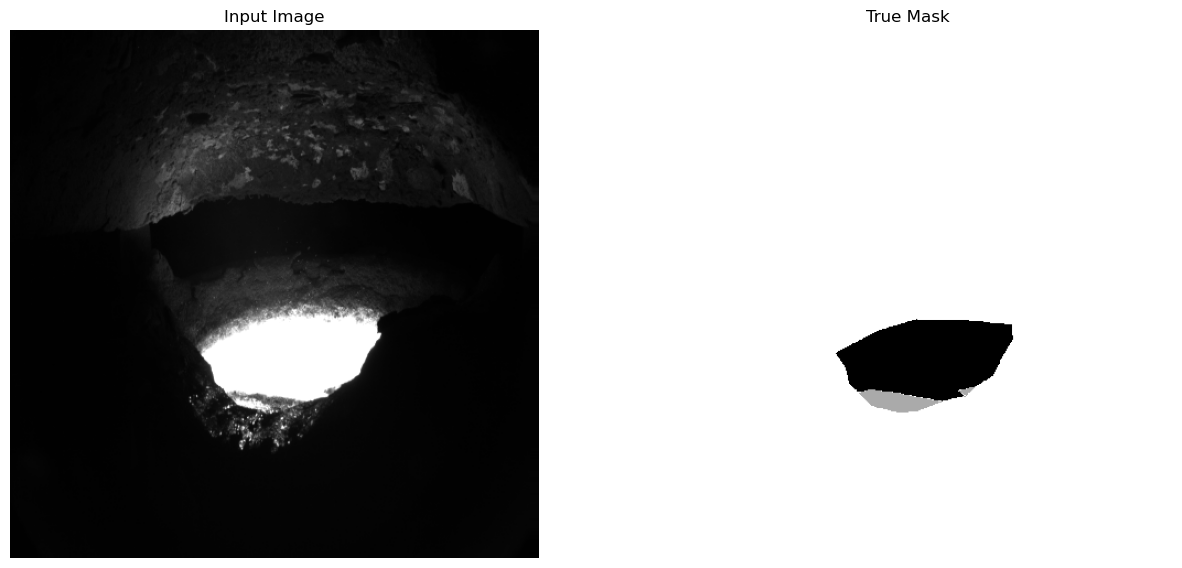

In [13]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  #sample_mask = tf.keras.layers.RandomFlip(mode="horizontal")(sample_image, training=True)
  #sample_mask = tf.keras.layers.RandomBrightness(factor=[0.1,0])(tf.expand_dims(sample_image, axis=0), training=True)
  sample_mask = tf.cast(sample_mask, tf.int64)
  print('Input Image: ', sample_image.numpy().min(), '----------- Adjusted Image: ', sample_mask.numpy().min(),)
  print('Input Image: ', sample_image.numpy().max(), '----------- Adjusted Image: ', sample_mask.numpy().max(),)
  print('Input Image: ', np.average(sample_image.numpy()), '----------- Adjusted Image: ', np.average(sample_mask.numpy()))
  display([sample_image, sample_mask])

In [14]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None,
               **kwargs):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype, **kwargs)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

  def get_config(self):
    config = super(UpdatedMeanIoU, self).get_config()
    return config

In [16]:
# build the U-Net
unet = UNetCompiled(input_size=(480,480,1), n_filters=32, n_classes=4)
#unet = tf.keras.models.load_model(model_path, custom_objects={'UpdatedMeanIoU':UpdatedMeanIoU})
#unet.summary()

#unet = unet_model(output_channels=1)
#unet = tf.keras.models.load_model(model_path)

unet.summary()

if one_hot:
    unet.compile(optimizer=tf.keras.optimizers.Adam(), 
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=4)])
else:
    unet.compile(optimizer=tf.keras.optimizers.Adam(), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[UpdatedMeanIoU(num_classes=4)])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 480, 480, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 480, 480, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

Train batch:
1/1 [==============================] - 0s 53ms/step


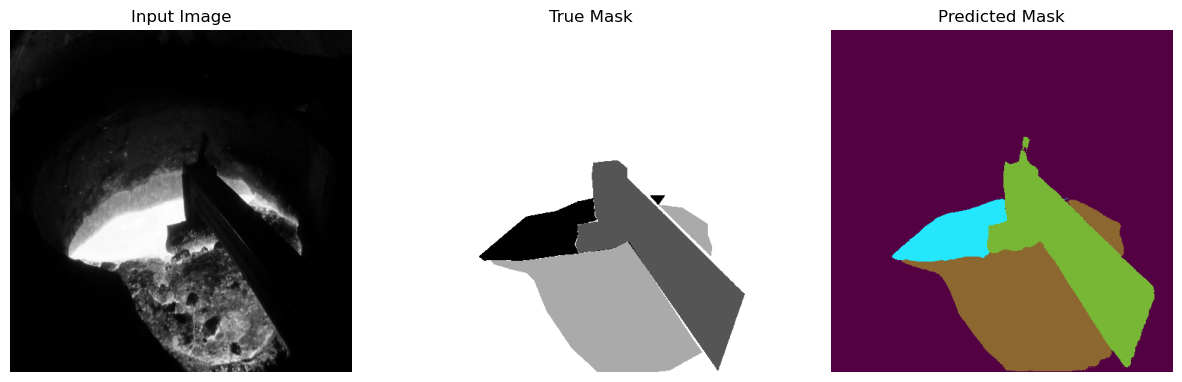

Test batch:
1/1 [==============================] - 0s 44ms/step


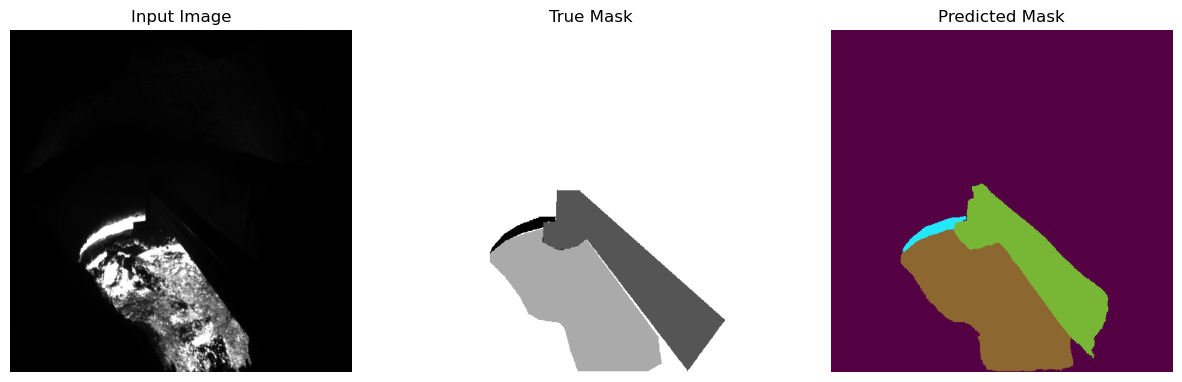


Sample Prediction after epoch 46

419/419 [==============================] - 43s 103ms/step - loss: 0.0335 - updated_mean_io_u_1: 0.9126 - val_loss: 0.1934 - val_updated_mean_io_u_1: 0.7777
Epoch 47/50
419/419 [==============================] - 42s 101ms/step - loss: 0.0307 - updated_mean_io_u_1: 0.9215 - val_loss: 0.1683 - val_updated_mean_io_u_1: 0.7691
Epoch 48/50
419/419 [==============================] - ETA: 0s - loss: 0.0403 - updated_mean_io_u_1: 0.9031
Epoch 48: saving model to /work/au321555/hiwi/model/multiclass_model_25-05_480x480x1/checkpoints/unet_model_epoch-48.ckpt
419/419 [==============================] - 43s 104ms/step - loss: 0.0403 - updated_mean_io_u_1: 0.9031 - val_loss: 0.1545 - val_updated_mean_io_u_1: 0.7567
Epoch 49/50
419/419 [==============================] - 42s 101ms/step - loss: 0.0312 - updated_mean_io_u_1: 0.9199 - val_loss: 0.1579 - val_updated_mean_io_u_1: 0.7734
Epoch 50/50
419/419 [==============================] - 42s 101ms/step - loss: 0.0290 - 

In [17]:
#define callback to save checkpoints
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath + 'unet_model_epoch-{epoch:02d}.ckpt', 
                                                   monitor='val_binary_io_u', 
                                                   save_weights_only=True, 
                                                   save_freq='epoch',
                                                    period=SAVE_PERIOD,
                                                   verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_io_u', mode='max', patience=3, min_delta=0.003, verbose=0, restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 15 == 0:
        clear_output(wait=True)
        print('Train batch:')
        show_predictions(train_batches, 1)
        print('Test batch:')
        show_predictions(test_batches, 1)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Load the previously saved weights (checkpoint):
#unet.load_weights(model_path + 'checkpoints/unet_model_epoch-69_val_binary_io_u-0.630546.ckpt')

# start model training
results = unet.fit(train_batches, batch_size=BATCH_SIZE, 
                   epochs=EPOCHS, validation_data=test_batches, 
                   validation_steps=VALIDATION_STEPS,
                   steps_per_epoch=STEPS_PER_EPOCH,
                   callbacks=[model_callback, 
                              tensorboard_callback, 
                              DisplayCallback()])

# model evaluation
#unet.evaluate(X_valid, y_valid)

#unet.save(model_path)

1/1 [==============================] - 0s 50ms/step


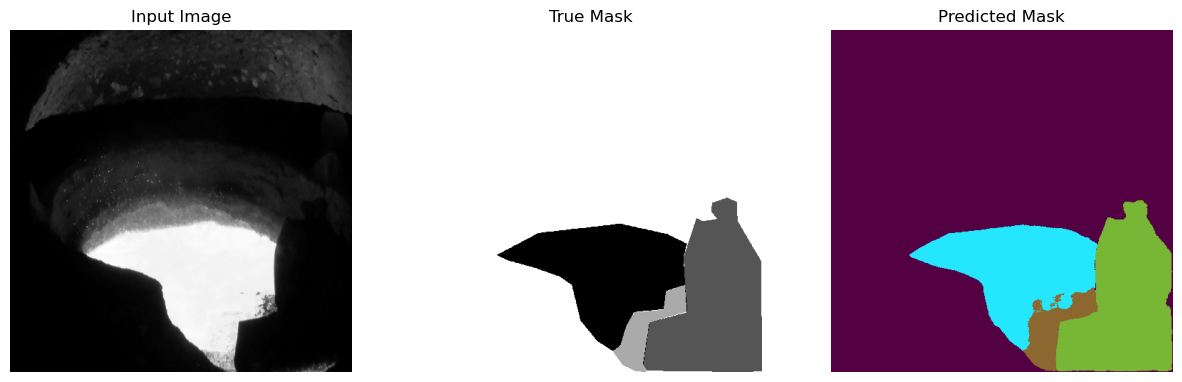

1/1 [==============================] - 0s 44ms/step


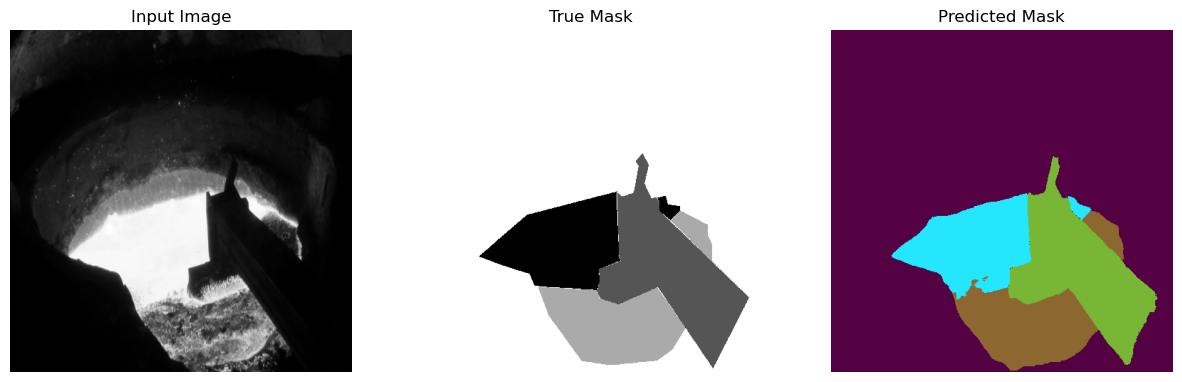

1/1 [==============================] - 0s 44ms/step


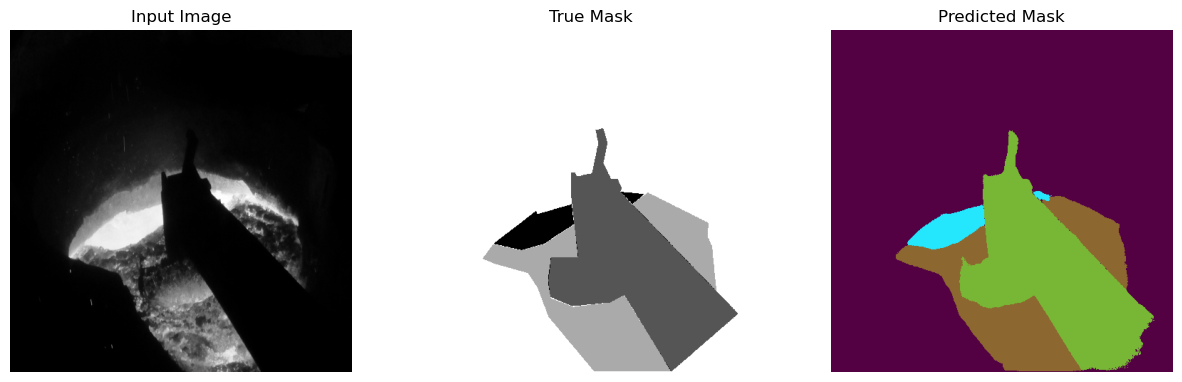

1/1 [==============================] - 0s 44ms/step


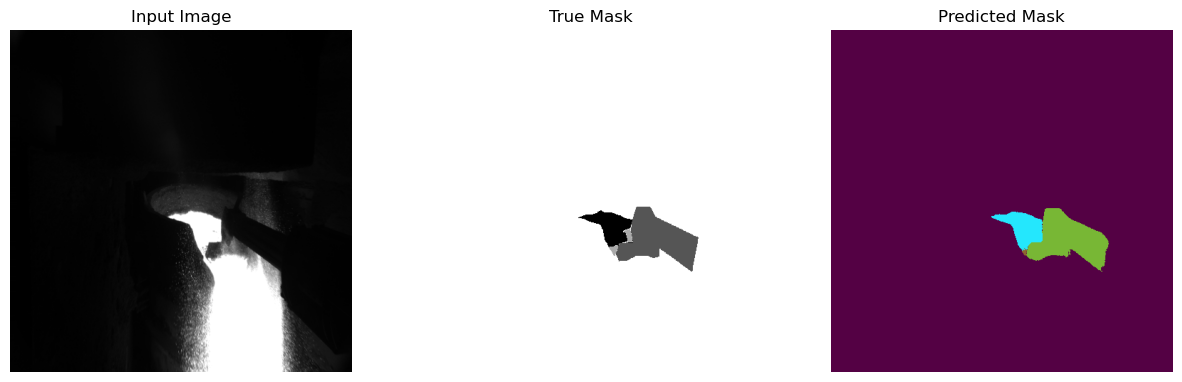

1/1 [==============================] - 0s 45ms/step


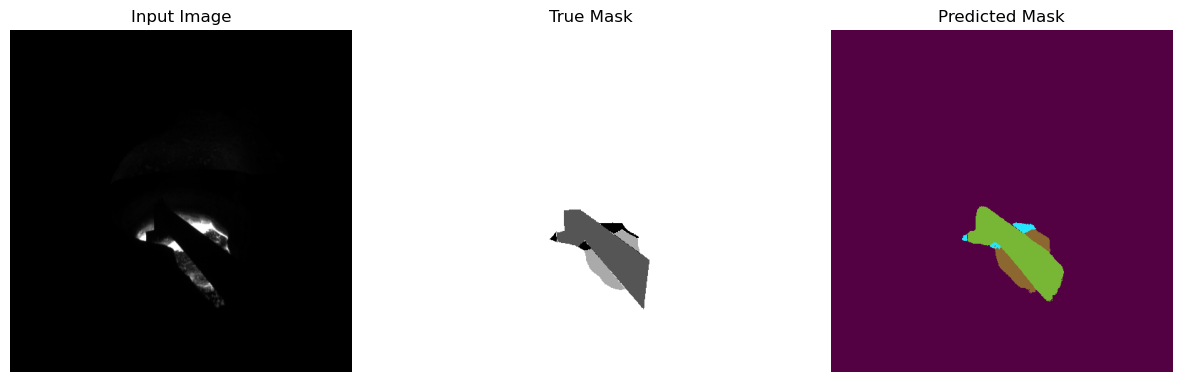

1/1 [==============================] - 0s 44ms/step


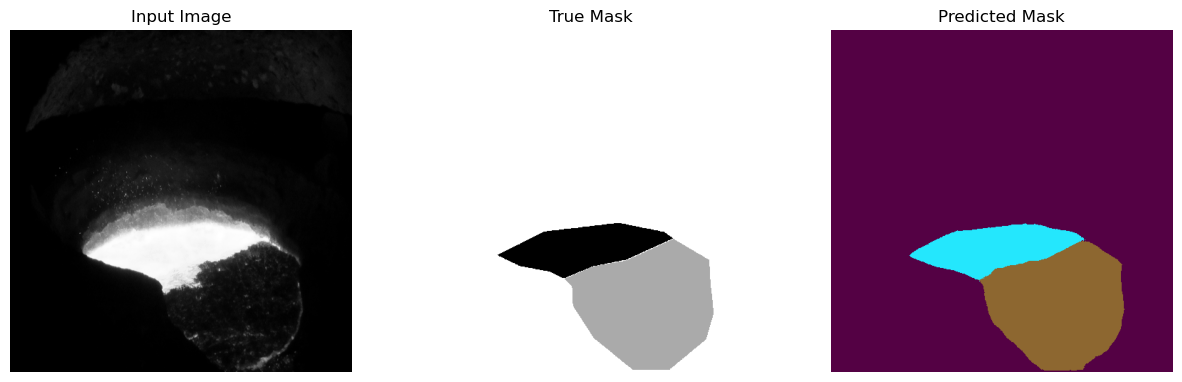

1/1 [==============================] - 0s 51ms/step


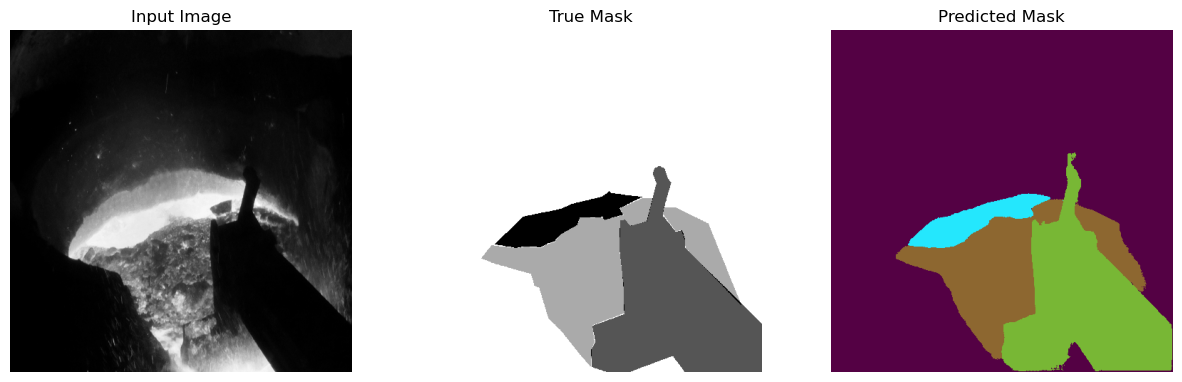

In [18]:
show_predictions(train_batches, 7)

1/1 [==============================] - 0s 47ms/step


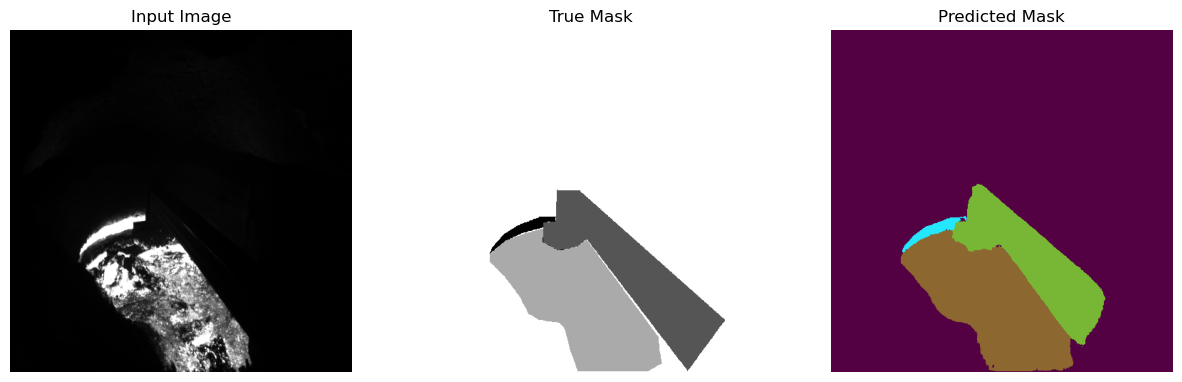

1/1 [==============================] - 0s 45ms/step


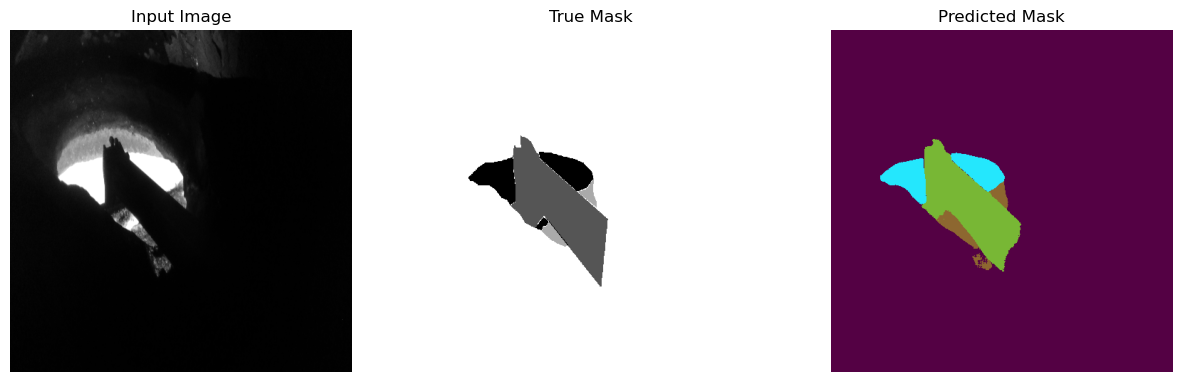

1/1 [==============================] - 0s 44ms/step


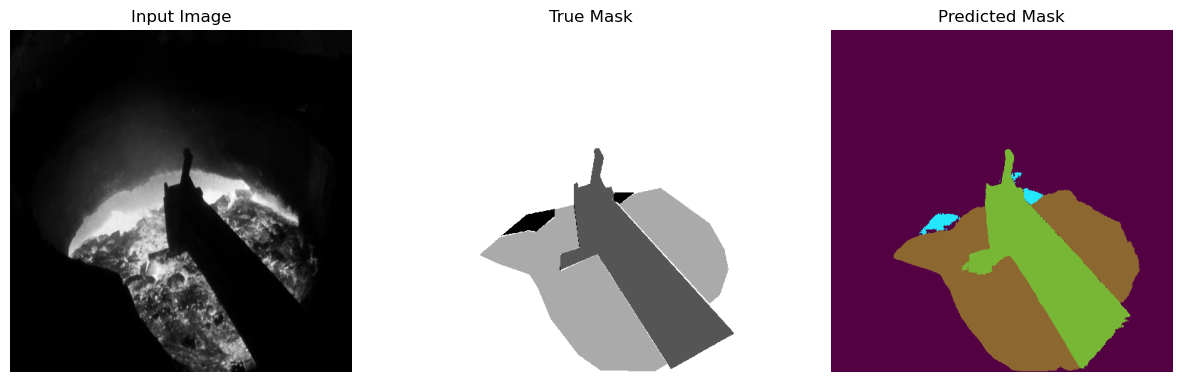

1/1 [==============================] - 0s 46ms/step


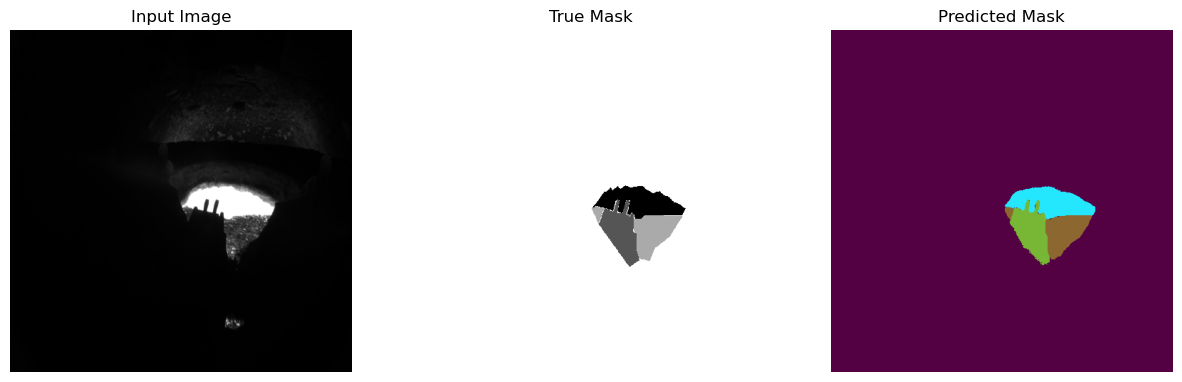

1/1 [==============================] - 0s 44ms/step


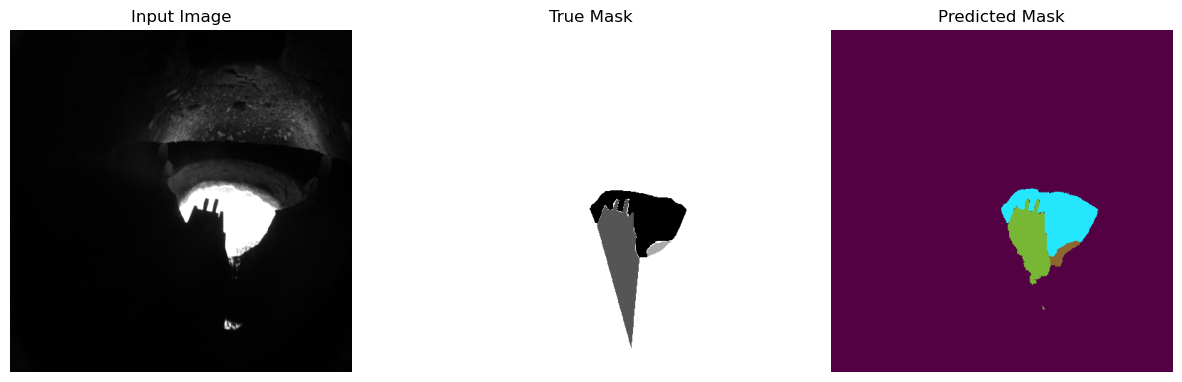

1/1 [==============================] - 0s 44ms/step


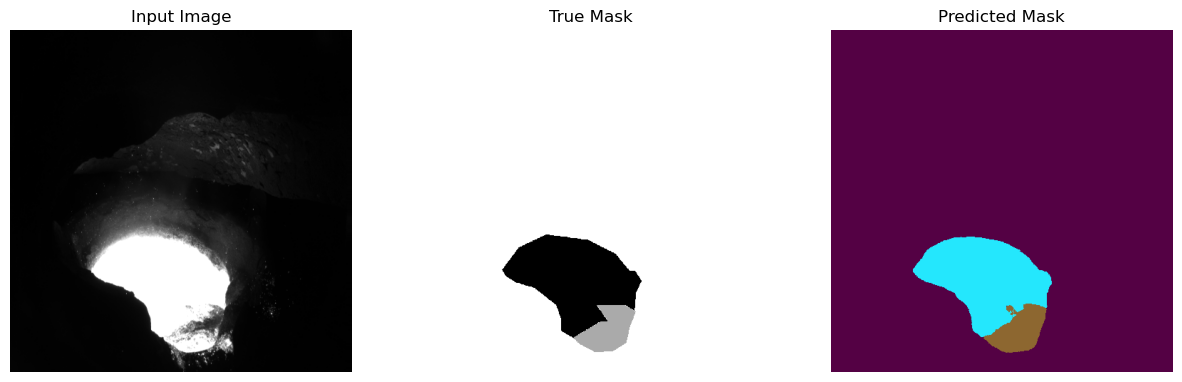

1/1 [==============================] - 0s 46ms/step


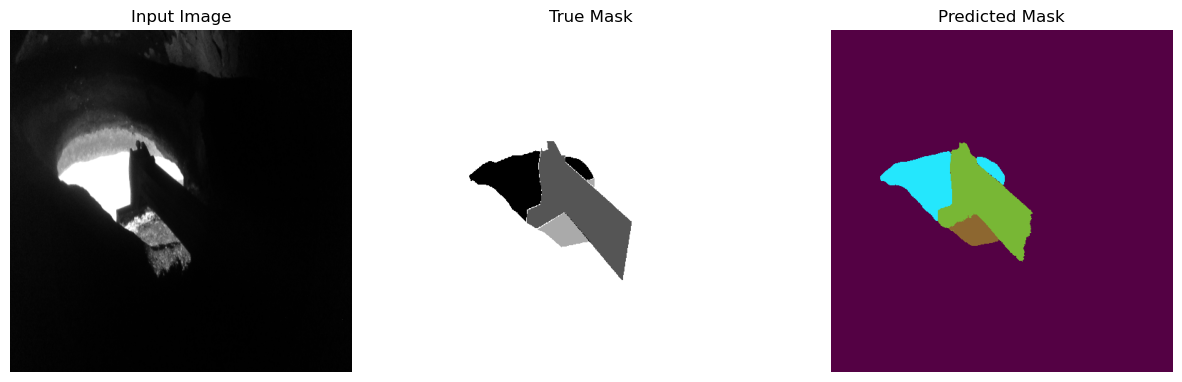

In [19]:
show_predictions(test_batches, 7)

In [20]:
unet.save(model_path)

INFO:tensorflow:Assets written to: /work/au321555/hiwi/model/multiclass_model_25-05_480x480x1/assets


INFO:tensorflow:Assets written to: /work/au321555/hiwi/model/multiclass_model_25-05_480x480x1/assets


1/1 [==============================] - 0s 444ms/step


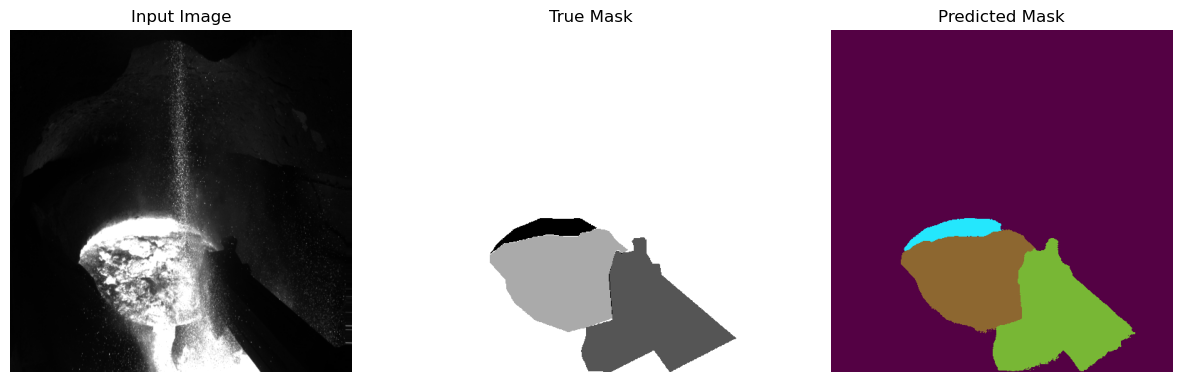

1/1 [==============================] - 0s 25ms/step


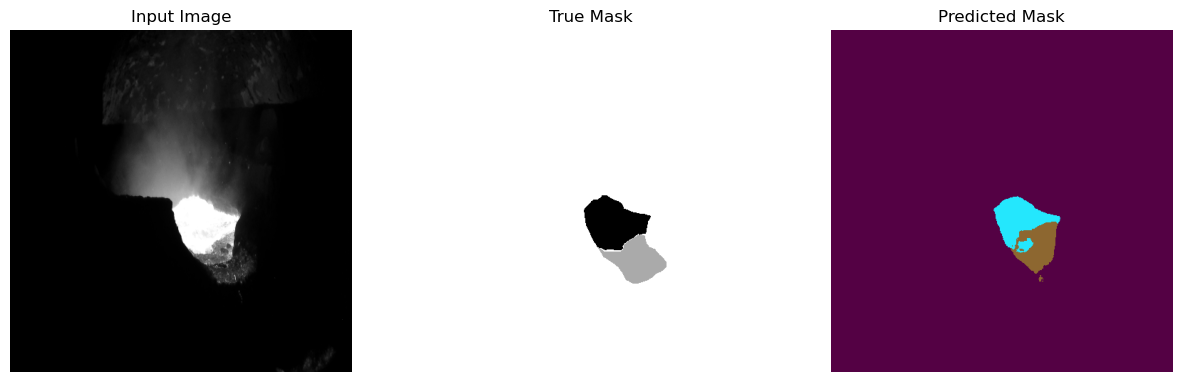

1/1 [==============================] - 0s 24ms/step


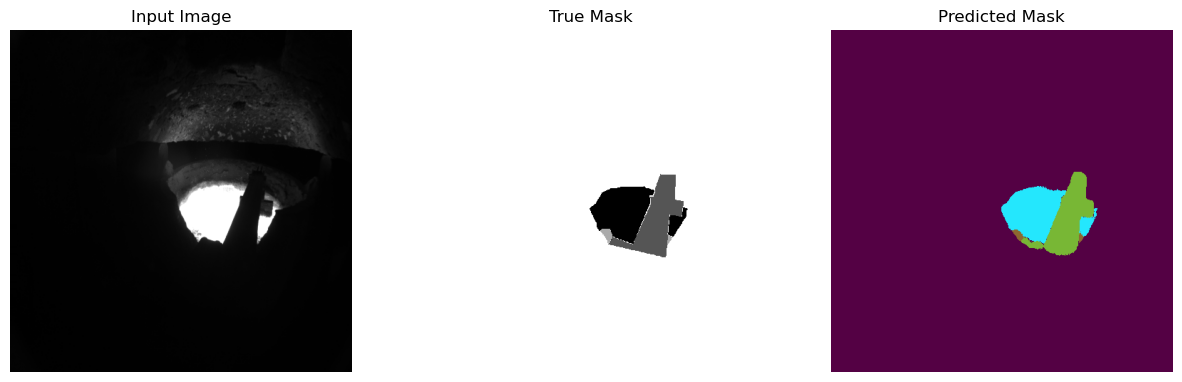

1/1 [==============================] - 0s 24ms/step


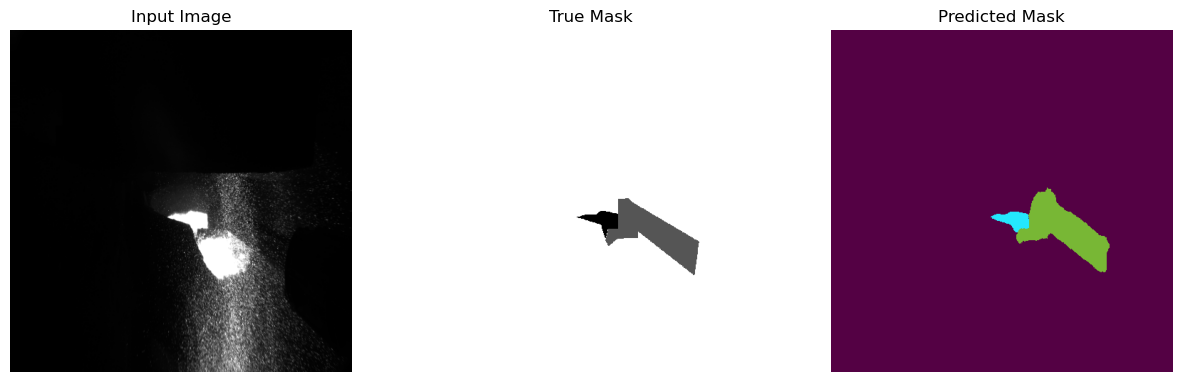

1/1 [==============================] - 0s 24ms/step


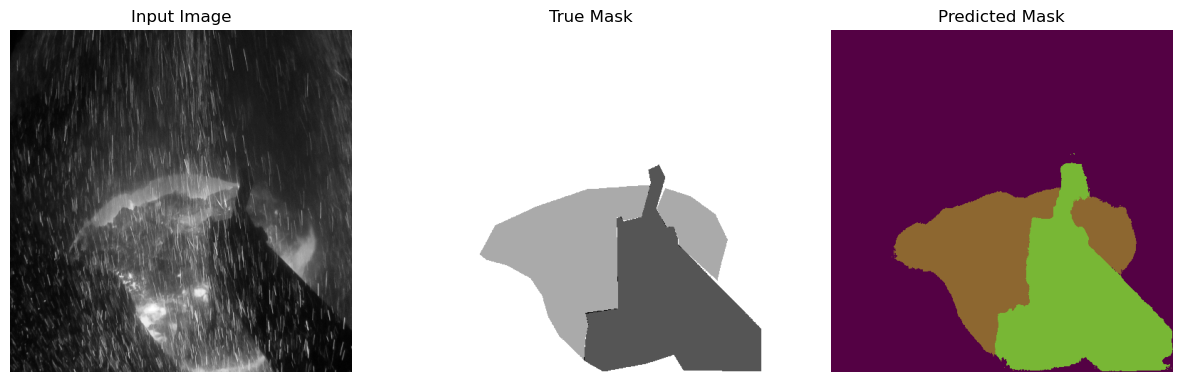

1/1 [==============================] - 0s 24ms/step


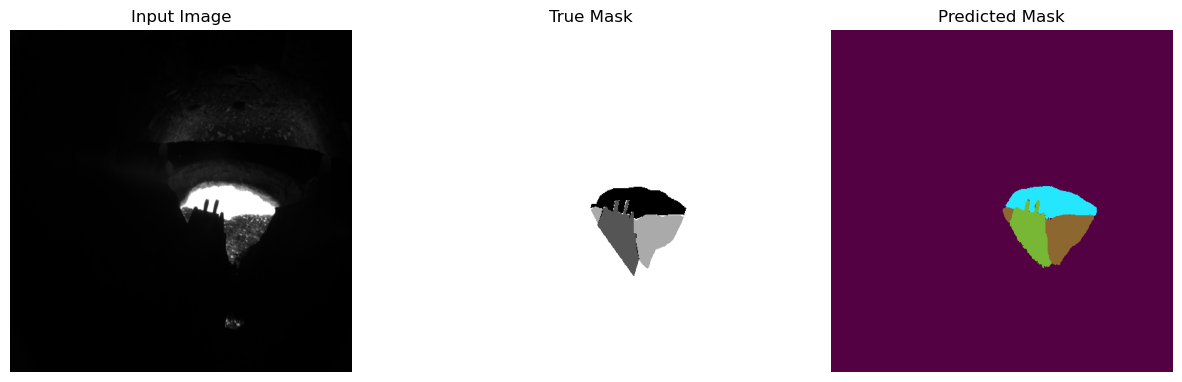

1/1 [==============================] - 0s 23ms/step


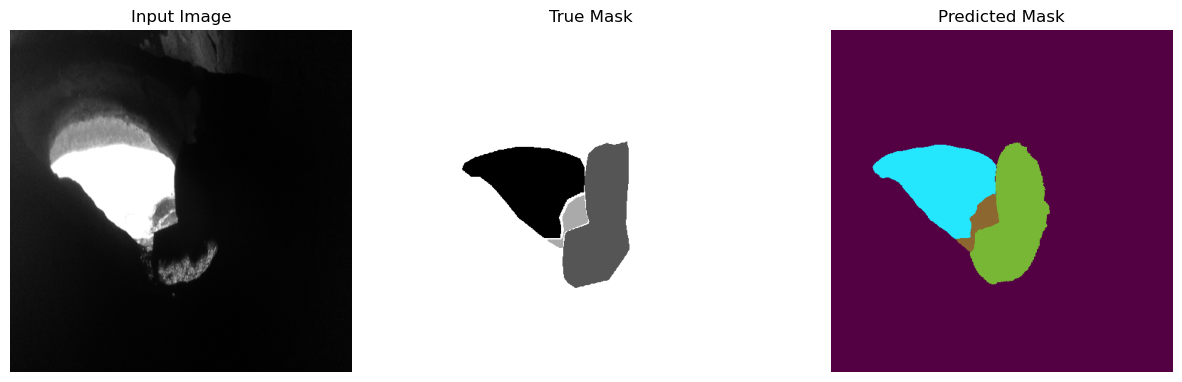

1/1 [==============================] - 0s 24ms/step


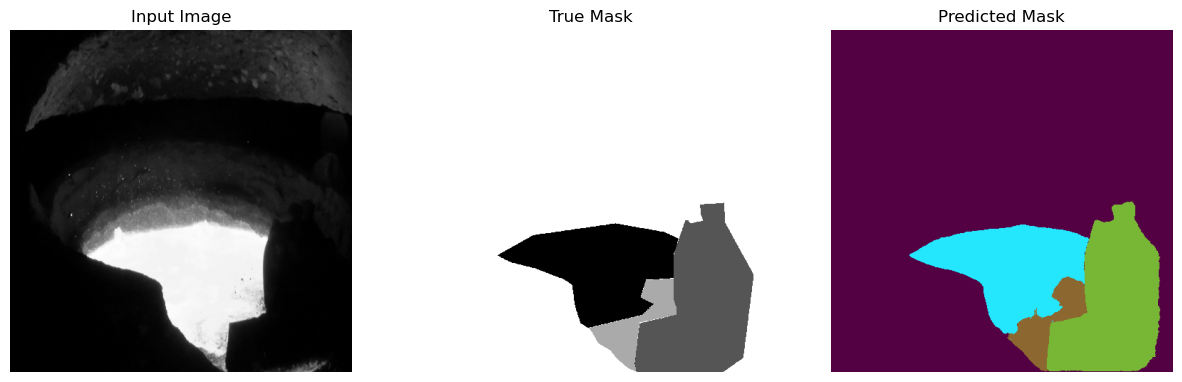

1/1 [==============================] - 0s 25ms/step


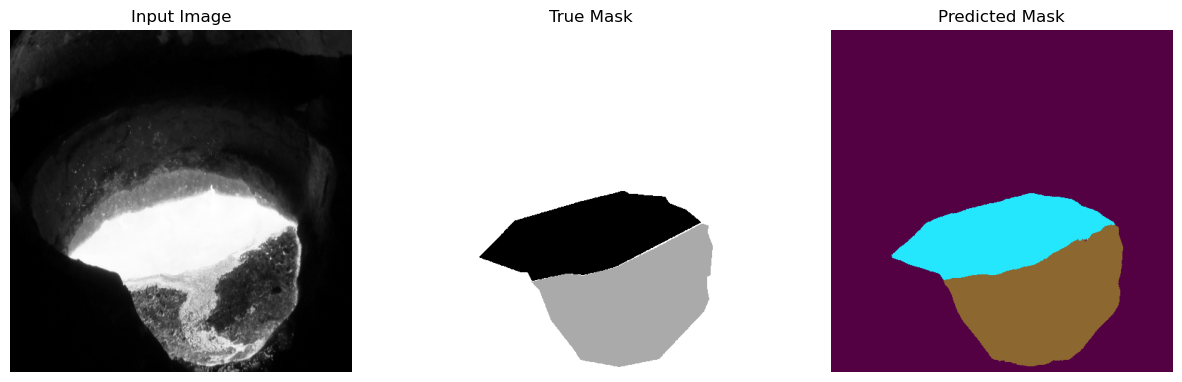

1/1 [==============================] - 0s 24ms/step


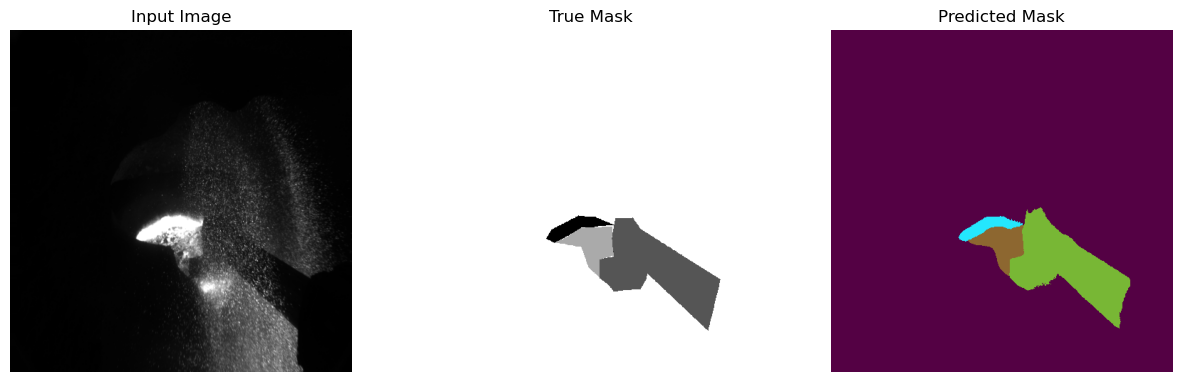

In [21]:
for i in range(10):
    rand_x = np.random.randint(0, len(X))
    sample_img, sample_mask = X[rand_x], y[rand_x]
    pred = unet.predict(sample_img[np.newaxis, ...])
    pred_mask = create_mask(pred)
    display([sample_img, sample_mask, pred_mask])

In [ ]:
# VisualizeResults(start=40, index=50)

# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(30, 30))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["updated_mean_io_u"], color='r', label = 'train acc')
axis[1].plot(results.history["val_updated_mean_io_u"], color='b', label = 'val acc')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

#%tensorboard --logdir logs
# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance